# Recommender Systems

# Библиотеки

In [3]:
#!pip install implicit

In [50]:
from abc import ABC, abstractmethod
from typing import Dict, List

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import datetime


# Данные

В качестве данных будем использовать датасет от Кино.Триколор.
Это информация о просмотрах пользователей различных фильмов и сериалов с названиями, описаниями и прочими фичами. 

**Обратите внимание, что вы можете парсить интернет, для получения дополнительных фичей! Только не забудьте описать, какие фичи вы взяли и где вы их достали!**   
Мы заранее поделили выборки на тренировочную и тестовую части, поэтому **просим** вас придерживаться следующих правил: с тренировочными данными разрешается делать **всё что угодно**, тестовую же часть **запрещается изменять**!  

Датасет представляет из себя 4 файла: тренировочную часть (`train_data.csv`), тестовую часть(`test_data.csv`), описание пользователей(`users_df.csv`) и описание айтемов(`items_df.csv`). 

In [5]:
data_folder = "./"

users_df = pd.read_csv(data_folder + "users_df.csv")
items_df = pd.read_csv(data_folder + "items_df.csv")

countries = pd.read_csv(data_folder + "countries.csv")
genres = pd.read_csv(data_folder + "genres.csv")
staff = pd.read_csv(data_folder + "staff.csv")

train_part = pd.read_csv(data_folder + "train_data.csv", parse_dates=["datetime"])
test_part = pd.read_csv(data_folder + "test_data.csv")
test_part = test_part.groupby("user_id").agg({"movie_id": list}).reset_index()


# Пользователи

In [ ]:
users_df.info()

## Какие есть признаки?

1. `user_id` – индентификатор пользователя, уникален для каждого
2. `age_category` – категориальный признак, показывающий возрастную группу пользователя
3. `income` – категориальный признак, показывающий зарплатную группу пользователя
4. `sex` – пол пользователя
5. `kids_flg` – наличие детей у пользователя
6. `education` – уровень образования пользователя

25-34    69235
18-24    55685
35-44    43550
45-54    10910
55-70     1038
Name: age_category, dtype: int64


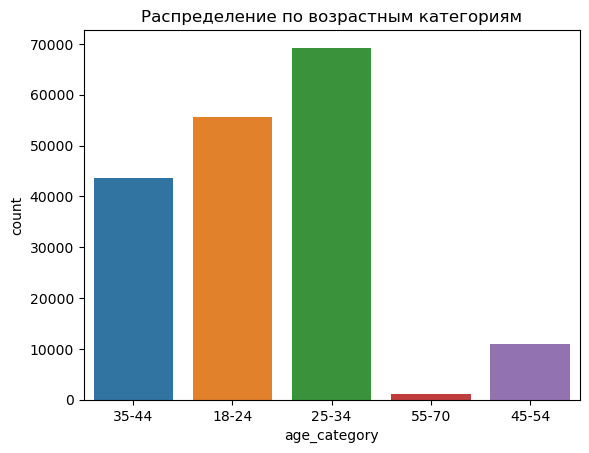

In [35]:
print(users_df['age_category'].value_counts())
sns.countplot(data=users_df, x='age_category')
plt.title('Распределение по возрастным категориям')
plt.show()

### 1. Возрастные категории
- **25-34**: 69,235 пользователей (наибольшее количество)
- **18-24**: 55,685 пользователей
- **35-44**: 43,550 пользователей
- **45-54**: 10,910 пользователей
- **55-70**: 1,038 пользователей (наименьшее количество)
**Вывод**: Основная аудитория находится в возрастной категории 25-34 года, что может указывать на то, что контент, предлагаемый вашей платформой, наиболее привлекателен для этой возрастной группы. Меньшее количество пользователей в старших возрастных категориях может означать, что контент не ориентирован на них или что они менее активны в использовании платформы.

In [36]:
 users_df['user_id'].nunique()

207377

средний          56686
низкий           54721
высокий          21578
очень высокий     3250
Name: income, dtype: int64


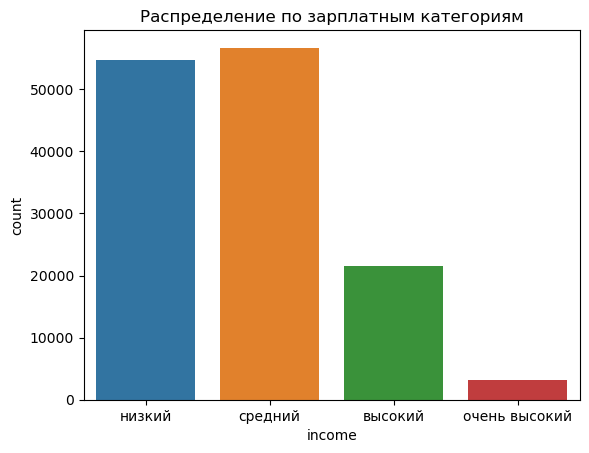

In [37]:
print(users_df['income'].value_counts())
sns.countplot(data=users_df, x='income')
plt.title('Распределение по зарплатным категориям')
plt.show()

### 3. Уровень дохода
- **Средний**: 56,686 пользователей
- **Низкий**: 54,721 пользователей
- **Высокий**: 21,578 пользователей
- **Очень высокий**: 3,250 пользователей

**Вывод** : Большинство пользователей имеют средний или низкий уровень дохода, что может указывать на то, что контент должен быть доступным и привлекательным для этой аудитории. Это также может повлиять на стратегию монетизации, например, на выбор между подпиской и рекламой.

Женский    67723
Мужской    64900
Name: sex, dtype: int64


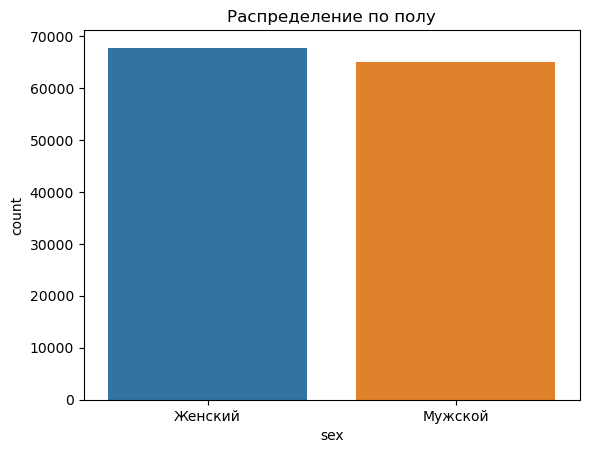

In [38]:
print(users_df['sex'].value_counts())
sns.countplot(data=users_df, x='sex')
plt.title('Распределение по полу')
plt.show()

Мне просто было интересно)

0.0    123382
1.0     63257
Name: kids_flg, dtype: int64


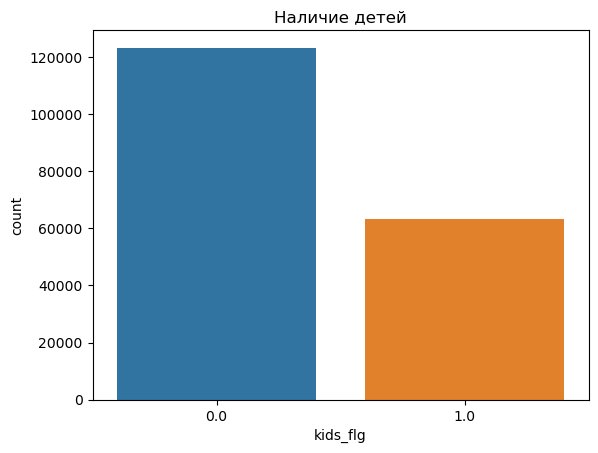

In [39]:
print(users_df['kids_flg'].value_counts())
sns.countplot(data=users_df, x='kids_flg')
plt.title('Наличие детей')
plt.show()

### 5. Наличие детей
- **Без детей (0.0)**: 123,382 пользователей
- **С детьми (1.0)**: 63,257 пользователей

**Вывод**: Большинство пользователей в данной выборке не имеют детей, что может указывать на то, что контент, предлагаемый платформой, в основном ориентирован на молодую аудиторию или на людей без семейных обязательств. Это также может повлиять на выбор контента, который может быть менее ориентирован на семейные ценности.

Среднее            70253
Высшее             52970
Неполное высшее    44141
Без образования     8906
Name: education, dtype: int64


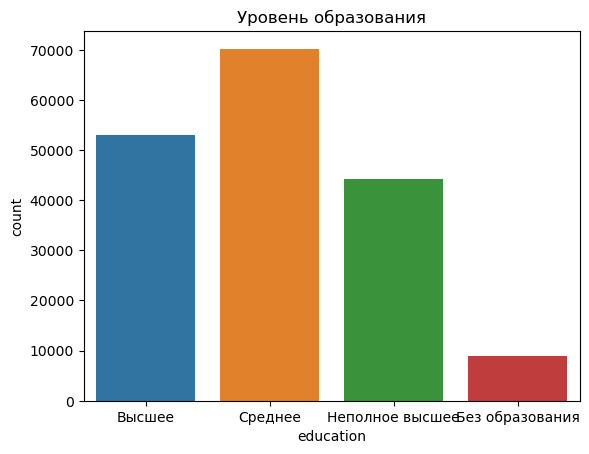

In [40]:
print(users_df['education'].value_counts())
sns.countplot(data=users_df, x='education')
plt.title('Уровень образования')
plt.show()

### 6. Уровень образования
- **Среднее**: 70,253 пользователей
- **Высшее**: 52,970 пользователей
- **Неполное высшее**: 44,141 пользователей
- **Без образования**: 8,906 пользователей

**Вывод**: Большинство пользователей имеют среднее образование, что может указывать на то, что контент должен быть доступным и понятным для широкой аудитории. Наличие значительного числа пользователей с высшим образованием также может означать, что контент может быть более сложным и глубоким для этой группы. Это гипотеза, не утверждение!

# Айтемы

In [7]:
items_df.head(4)

,id,title,year,date_publication,description,genres,countries,staff,title_orig,age_rating,keywords
0,0,"Мама, я дома",2022-01-01,2022-11-23T00:00:00,Где-то в глубинке вместе с дочерью и внуком жи...,[97],[238],"[1883, 33655, 25890, 1001, 12051, 10110, 16895]",NaN,NaN,NaN
1,1,Три метра над уровнем неба,2010-01-01,NaN,"История любви парня и девушки, принадлежащих к...","[138, 97, 294]",[242],"[18168, 23444, 10850, 21847, 30555, 24469, 268...",Tres metros sobre el cielo,16.0,"Три, метра, над, уровнем, неба, 2010, Испания,..."
2,2,Детектив ди и тайна призрачного пламени,2010-01-01,NaN,"690 год нашей эры, Китай. Первая императрица д...","[294, 302]","[250, 117]","[3933, 19953, 32174, 30640, 14127, 32141, 2549...",NaN,NaN,NaN
3,3,Капитан,2017-01-01,2022-10-20T00:00:00,Вторая мировая война подходит к концу. В это в...,"[97, 303, 143, 319]","[188, 212, 0]","[16006, 12217, 30668, 28806, 16172, 5045, 1663...",NaN,NaN,NaN


In [102]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7427 entries, 0 to 7426
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                7427 non-null   int64  
 1   title             7427 non-null   object 
 2   year              7427 non-null   object 
 3   date_publication  4923 non-null   object 
 4   description       7288 non-null   object 
 5   genres            7427 non-null   object 
 6   countries         7427 non-null   object 
 7   staff             7427 non-null   object 
 8   title_orig        2963 non-null   object 
 9   age_rating        3316 non-null   float64
 10  keywords          3305 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 638.4+ KB


## Какие есть признаки?

1. `id` – индентификатор айтема, уникален для каждого
2. `title` – Название на русском языке
3. `year` – Дата выхода
4. `date_publication` – дата публикации на платформе
5. `description` – описание (на русском)
6. `genres` - список жанров (представлен строкой)
7. `countries` – страна издания
8. `staff` – режиссер(ы), актёры
9. `title_orig` – название на английском
10. `age_rating` – возрастной рейтинг картины
11. `keywords` – ключевые слова, описывающие картину

In [41]:
items_df['id'].nunique()

7427

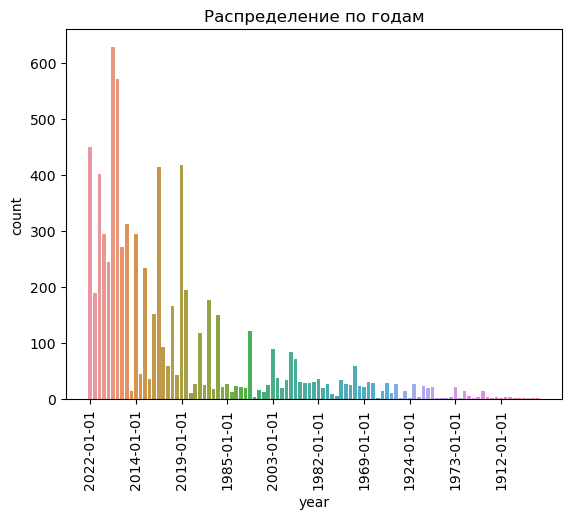

In [106]:
sns.countplot(data=items_df, x='year')
plt.title('Распределение по годам')
plt.locator_params(axis='x', nbins=10)
plt.xticks(rotation=90)
plt.show()

In [91]:
print(items_df['year'].value_counts())

2021-01-01    628
2018-01-01    571
2022-01-01    450
2019-01-01    418
2020-01-01    413
2017-01-01    402
2016-01-01    313
2014-01-01    295
2015-01-01    294
2013-01-01    272
2012-01-01    245
2011-01-01    233
2008-01-01    194
2010-01-01    189
2009-01-01    176
2007-01-01    166
2006-01-01    152
2023-01-01    150
2004-01-01    122
2005-01-01    118
2002-01-01     93
2003-01-01     90
2001-01-01     84
1999-01-01     71
2000-01-01     59
1998-01-01     58
1995-01-01     45
1997-01-01     42
1989-01-01     38
1982-01-01     36
1987-01-01     35
1979-01-01     34
1968-01-01     33
1984-01-01     31
1988-01-01     30
1994-01-01     30
1992-01-01     29
1990-01-01     29
1991-01-01     28
1976-01-01     28
1981-01-01     27
1966-01-01     26
1993-01-01     26
1967-01-01     26
1985-01-01     26
1978-01-01     26
1980-01-01     25
1983-01-01     25
1975-01-01     25
1986-01-01     24
1996-01-01     24
1961-01-01     23
1965-01-01     22
1964-01-01     21
1969-01-01     21
1973-01-01

In [63]:
items_df['age_rating'].value_counts()

16.0    1373
12.0     733
18.0     693
6.0      319
0.0      189
21.0       9
Name: age_rating, dtype: int64

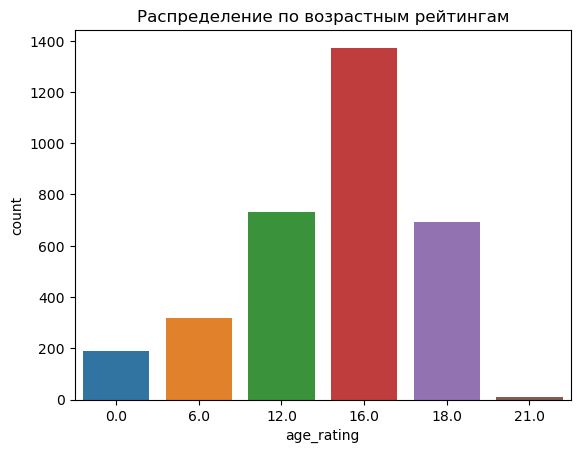

In [64]:
sns.countplot(data=items_df, x='age_rating')
plt.title('Распределение по возрастным рейтингам')
plt.show()

In [67]:
items_df['genres']

0                      [97]
1            [138, 97, 294]
2                [294, 302]
3       [97, 303, 143, 319]
4                 [138, 97]
               ...         
7422              [138, 97]
7423              [85, 303]
7424              [138, 85]
7425                  [247]
7426                  [261]
Name: genres, Length: 7427, dtype: object

In [117]:
df = items_df.copy()
numeric_df = df.select_dtypes(include=['number'])
numeric_df = numeric_df.dropna()

C=len(df.columns)
L=len(df.index)
CN=df.count() #количество
NP=((L-CN)/L)*100 #процент пропущенных значений
MN=df.min(numeric_only=True) #минимум
Q1=numeric_df.quantile(q=0.25) #первый квартиль
MA=df.mean(numeric_only=True) #среднее значение
ME=df.median(numeric_only=True) #медиана
Q3=numeric_df.quantile(q=0.75) #третий квартиль
MX=df.max(numeric_only=True) #максимум
ST=df.std(numeric_only=True) #стандартное отклонение
P=df.drop('genres', axis=1).nunique() #мощность
IQ=Q3-Q1 #интерквартильный размах

In [118]:
frame = pd.concat([CN, NP, MN, Q1, MA, ME, Q3, MX, ST, P, IQ], axis=1, join="inner")
frame=frame.T
f=pd.DataFrame(frame)
f.index=['Количество', 'Процент пропусков', 'Минимум', 'Первый квартиль','Среднее', 'Медиана', 'Третий квартиль', 'Максимум','Стандартное отклонение', 'Мощность', 'Интерквартильный размах']
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
f1=f.style.apply(lambda x: ["background-color:tomato" if i==1 else "" for i in x], axis=1, subset=(["Мощность"], slice(None))).apply(lambda x: ["background-color:tomato" if i>=60 else "" for i in x], axis=1, subset=(["Процент пропусков"], slice(None))).apply(lambda x: ["background-color:steelblue" if (i<30 and i>0) else "" for i in x], axis=1, subset=(["Процент пропусков"], slice(None))).apply(lambda x: ["background-color:limegreen" if i==0 else "" for i in x], axis=1, subset=(["Процент пропусков"], slice(None)))
f1

,id,age_rating
Количество,7427.000000,3316.000000
Процент пропусков,0.000000,55.352094
Минимум,0.000000,0.000000
Первый квартиль,1849.750000,12.000000
Среднее,3713.000000,13.673402
Медиана,3713.000000,16.000000
Третий квартиль,5563.250000,16.000000
Максимум,7426.000000,21.000000
Стандартное отклонение,2144.134557,4.821373
Мощность,7427.000000,6.000000


# Страны выпуска фильмов

In [26]:
countries.head()

,id,name
0,0,Франция
1,1,Мальта
2,5,Новая Зеландия
3,8,Куба
4,10,Пуэрто-Рико


# Жанры

In [27]:
genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      96 non-null     int64 
 1   name    96 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


# Актеры, режиcсеры

In [29]:
staff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35684 entries, 0 to 35683
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      35684 non-null  int64 
 1   name    35684 non-null  object
 2   role    35684 non-null  object
dtypes: int64(1), object(2)
memory usage: 836.5+ KB


# Просмотры пользователей

### Тренировачные данные

In [11]:
print(f"Число тренировачных интеракций: {len(train_part):,}")
train_part.head()

Число тренировачных интеракций: 1,251,871


,id,datetime,user_id,movie_id,duration,is_train
0,0,2023-04-06 15:00:00.071114+03:00,10250,427.0,485.0,True
1,1,2023-04-06 15:00:01.123928+03:00,2062,1521.0,129.0,True
2,2,2023-04-06 15:00:03.957246+03:00,12980,4598.0,2795.0,True
3,3,2023-04-06 15:00:04.990565+03:00,30646,5324.0,5094.0,True
4,4,2023-04-06 15:00:10.495017+03:00,43069,4291.0,75.0,True


In [69]:
train_part.describe()

,id,user_id,movie_id,duration,watched
count,1.251871e+06,1.251871e+06,1.251871e+06,1.251871e+06,1251871.0
mean,9.089418e+05,4.256487e+04,3.696708e+03,2.796361e+03,1.0
std,5.885869e+05,5.535238e+04,2.129806e+03,2.736542e+03,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.0
25%,4.118625e+05,5.954000e+03,1.871000e+03,2.010000e+02,1.0
50%,8.674890e+05,1.968700e+04,3.672000e+03,1.862000e+03,1.0
75%,1.339846e+06,5.533800e+04,5.584000e+03,5.181000e+03,1.0
max,2.477903e+06,2.638740e+05,7.426000e+03,4.573800e+04,1.0


In [79]:
df = train_part.copy()
numeric_df = df.select_dtypes(include=['number'])
numeric_df = numeric_df.dropna()

C=len(df.columns)
L=len(df.index)
CN=df.count() #количество
NP=((L-CN)/L)*100 #процент пропущенных значений
MN=df.min() #минимум
Q1=numeric_df.quantile(q=0.25) #первый квартиль
MA=df.mean(numeric_only=True) #среднее значение
ME=df.median(numeric_only=True) #медиана
Q3=numeric_df.quantile(q=0.75) #третий квартиль
MX=df.max() #максимум
ST=df.std() #стандартное отклонение
P=df.nunique() #мощность
IQ=Q3-Q1 #интерквартильный размах

In [80]:
frame = pd.concat([CN, NP, MN, Q1, MA, ME, Q3, MX, ST, P, IQ], axis=1, join="inner")
frame=frame.T
f=pd.DataFrame(frame)
f.index=['Количество', 'Процент пропусков', 'Минимум', 'Первый квартиль','Среднее', 'Медиана', 'Третий квартиль', 'Максимум','Стандартное отклонение', 'Мощность', 'Интерквартильный размах']
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
f1=f.style.apply(lambda x: ["background-color:tomato" if i==1 else "" for i in x], axis=1, subset=(["Мощность"], slice(None))).apply(lambda x: ["background-color:tomato" if i>=60 else "" for i in x], axis=1, subset=(["Процент пропусков"], slice(None))).apply(lambda x: ["background-color:steelblue" if (i<30 and i>0) else "" for i in x], axis=1, subset=(["Процент пропусков"], slice(None))).apply(lambda x: ["background-color:limegreen" if i==0 else "" for i in x], axis=1, subset=(["Процент пропусков"], slice(None)))
f1

,id,user_id,movie_id,duration,watched
Количество,1251871,1251871,1251871,1251871,1251871
Процент пропусков,0.000000,0.000000,0.000000,0.000000,0.000000
Минимум,0,0,0.000000,1.000000,1
Первый квартиль,411862.500000,5954.000000,1871.000000,201.000000,1.000000
Среднее,908941.791023,42564.873773,3696.708015,2796.360801,1.000000
Медиана,867489.000000,19687.000000,3672.000000,1862.000000,1.000000
Третий квартиль,1339845.500000,55338.000000,5584.000000,5181.000000,1.000000
Максимум,2477903,263874,7426.000000,45738.000000,1
Стандартное отклонение,588586.936151,55352.379817,2129.806280,2736.541825,0.000000
Мощность,1251871,207377,5269,12970,1


### Тестовые данные

In [30]:
print(f"Число тестовых пользователей: {len(test_part):,}")
print(test_part.head())

Число тестовых пользователей: 66,900
   user_id                                           movie_id  \
0        0  [12.0, 6201.0, 5542.0, 2025.0, 190.0, 5358.0, ...   
1        1  [2515.0, 1540.0, 5210.0, 1608.0, 3590.0, 7215....   
2        2  [5998.0, 190.0, 7327.0, 947.0, 3814.0, 876.0, ...   
3        3  [4812.0, 3935.0, 802.0, 4459.0, 4340.0, 5975.0...   
4        4  [152.0, 195.0, 800.0, 2266.0, 6634.0, 7412.0, ...   

                                     toppopular_recs  
0  [484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0,...  
1  [484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0,...  
2  [484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0,...  
3  [484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0,...  
4  [484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0,...  


### Обратите внимание, что формат данных тестовой и тренировочной частей отличается. 
#### Это сделано для того, чтобы вы могли использовать дополнительную информацию в своих моделях, например такую как время просмотра (`duration`), а так же дату последнего просмотра (`datetime`)
#### При этом на тестовых данных такой информации нет, так как мы не можем смотреть в будущее.     

#### Тестовые данные также приведены в удобный для подсчета метрик вид.

# Метрики

#### Кратко расскажем про метрики, которые мы будем использовать для измерения качества наших моделей.  

Мы будем смотреть всего на две метрики: **ndcg** и **recall**.  
Все метрики измеряются до какой-то позиции, у нас это будет **10**. То есть мы отдаем 10 самых подходящих пользователю айтемов по мнению модели и говорим, что это и есть наши рекомендации, качество которых мы хотим оценить.  

**ndcg** показывает, как модель справляется с задачей ранжирования, то есть ставит просмотренные айтемы выше непросмотренных
**recall** показывает, как много релевантных айтемов модель выдаёт в топе (смысл как в задаче классификации)

*Для обоих метрик лучше та, которая как можно ближе к **1.0***

Не бойтесь, если вам сейчас что-то непонятно, подробнее про метрики мы расскажем на смене или можете почитать в интернете:)

#### Ниже представлен код реализации, пожалуйста, не меняйте его!

In [18]:
# ACHTUNG! DO NOT TOUCH 

def ndcg_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores: np.ndarray) -> float:
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )


def recall_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt


def evaluate_recommender(df: pd.DataFrame, model_preds_col: str, gt_col: str = "movie_id") -> Dict[str, float]:
    metric_values = []

    for _, row in df.iterrows():
        metric_values.append(
            (ndcg_metric(row[gt_col], row[model_preds_col]), recall_metric(row[gt_col], row[model_preds_col]))
        )

    return {"ndcg": np.mean([x[0] for x in metric_values]), "recall": np.mean([x[1] for x in metric_values])}

#### Класс, от которого стоит наследовать все ваши модели, чтобы эксперименты было проще проводить

In [13]:
class BaseRecommender(ABC):
    def __init__(self):
        self.trained = False

    @abstractmethod
    def fit(self, df: pd.DataFrame) -> None:
        # реализация может быть любой, никаких ограничений

        # не забудьте про
        self.trained = True

    @abstractmethod
    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        # реализация может быть любой, НО
        # должен возвращать список массивов из movie_id, которые есть в `item_df`, чтобы корректно работал подсчет метрик
        pass

### Перейдем к моделям, начнем с супер простого подхода – давайте всем рекомендовать топ популярных (по числу просмотров) айтемов

# Baseline #1 – Топ Популярных

In [14]:
class TopPopular(BaseRecommender):
    def __init__(self):
        super().__init__()

    def fit(self, df: pd.DataFrame, item_id_col: str = "movie_id") -> None:
        # считаем популярность айтемов
        self.recommendations = df[item_id_col].value_counts().index.values
        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> np.ndarray:
        assert self.trained
        # возвращаем для всех одно и то же
        return [self.recommendations[:topn]] * len(df)


toppop = TopPopular()
toppop.fit(train_part)
test_part["toppopular_recs"] = toppop.predict(test_part)
test_part.head()

,user_id,movie_id,toppopular_recs
0,0,"[12.0, 6201.0, 5542.0, 2025.0, 190.0, 5358.0, ...","[484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0,..."
1,1,"[2515.0, 1540.0, 5210.0, 1608.0, 3590.0, 7215....","[484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0,..."
2,2,"[5998.0, 190.0, 7327.0, 947.0, 3814.0, 876.0, ...","[484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0,..."
3,3,"[4812.0, 3935.0, 802.0, 4459.0, 4340.0, 5975.0...","[484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0,..."
4,4,"[152.0, 195.0, 800.0, 2266.0, 6634.0, 7412.0, ...","[484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0,..."


##### Посмотрим на метрики, для этого передаем тестовый датафрейм и колонку с предсказаниями, в нашем случае это `toppopular_recs`  

In [19]:
evaluate_recommender(df=test_part, model_preds_col="toppopular_recs")


{'ndcg': 0.1213225408775555, 'recall': 0.05789212284812527}

#### Не пугайтесь таких маленьких значений, в RecSys задачах часто очень тяжело подстроиться под данные, поэтому абсолютные значения невелики. Чтобы по-настоящему оценить качество вашей модели, нужно сранвить ее с каким-то простым решением, которое можно считать отправной точкой. Наш бейзлайн с популярными фильмами как раз подходит!

### Теперь возьмем подход посложнее, уже математически подкованный
Мы можем представить просмотры пользователей, как матрицу, где по столбцам будут отложены айтемы, а по строкам – пользователи. В `[i,j]` ячейке будет стоять 1, если пользователь смотрел фильм/сериал и 0, если нет.  
Тогда нашей задачей будет разложить исходную матрицу на две: матрицу пользователей и матрицу айтемов, перемножив которые, мы бы максимально приблизили известные нам единички. 
Такой подход позволит нам заполнить все пропуски в нашей матрице, то есть все нули. 

Для этого метода будем использовать модель **Alternating Least Squares (ALS)**. Она оптимизирует наши матрицы таким образом, чтобы мы хорошо восстанавливали все единички. 
Подробнее про модель можно почитать в [документации](https://benfred.github.io/implicit/), или, например, [тут](https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe), или как всегда – в интернете.


# Baseline #2 – Матричное разложение

In [20]:
class ALS(BaseRecommender):
    # здесь вынесены только основные гиперпараметры модели, все вы можете посмотреть в документации
    def __init__(
        self, factors: int = 100, regularization: float = 0.01, alpha: float = 1.0, iterations: int = 5, **kwargs
    ) -> None:
        super().__init__()
        self.model = AlternatingLeastSquares(
            factors=factors, regularization=regularization, alpha=alpha, iterations=iterations, **kwargs
        )
        self.trained = False

    def fit(
        self, df: pd.DataFrame, item_col: str = "movie_id", user_col: str = "user_id", value_col: str = None
    ) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values

        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)
        self.sparse = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)
        self.model.fit(self.sparse)

        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        assert self.trained

        all_recs = []

        users = self.user_encoder.transform(df["user_id"])
        for user in tqdm(users, desc="predicting", leave=False):
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse[user], N=topn)[0]
            all_recs.append(self.item_encoder.inverse_transform(encoded_rec_items))

        return all_recs

In [31]:
als_rec = ALS(iterations=1, factors=2, random_state=42)
als_rec.fit(train_part)
test_part["als_recs"] = als_rec.predict(test_part)

AttributeError: 'NoneType' object has no attribute 'split'

#### Снова считаем метрики 

In [ ]:
evaluate_recommender(test_part, model_preds_col="als_recs")


### Ой-ой, кажется, что качество стало хуже, чем у популярных фильмов. Возможно мы плохо обучили модель, не самым правильным образом обработали данные, или она просто не подходит для этих данных, в любом случае, вам предстоит узнать можно ли обогнать `toppop` на данном датасете.

## Сделаем небольшой EDA наших предсказаний от ALS.

### Посмотрим, что наш алгоритм чаще всего рекомендует первым делом:

In [ ]:
first_items = pd.DataFrame([x[0] for x in test_part["als_recs"].values], columns=["id"])
first_items = (
    first_items.merge(items_df[["id", "title"]], on="id").groupby("title").size().sort_values(ascending=False)
)
first_items /= first_items.sum()
first_items.head(10).plot(kind="bar")
plt.ylabel("Доля от всех рекомендаций")
plt.title("Распредление фильмов на первых местах")
plt.show()


#### Посмотрим на похожие фильмы к фильму "Аватар: Путь воды", согласно als

In [ ]:
items_df[items_df["title"] == 'Аватар: Путь воды']


In [ ]:
def get_similar_films(title, N=10):
    item_id = items_df[items_df["title"] == title]['id'].values[0]

    similar_encoded_ids = als_rec.model.similar_items(
        als_rec.item_encoder.transform([item_id]), N=N, filter_items=als_rec.item_encoder.transform([item_id])
    )[0][0]
    similar_ids = als_rec.item_encoder.inverse_transform(similar_encoded_ids)
    return items_df[items_df["id"].isin(similar_ids)]["title"]


In [ ]:
get_similar_films("Аватар: Путь воды")

#### Получается, что "Аватар: Путь воды" и "31 июня" довольно близки.... возможно, возможно

# Так что же нужно сделать?

### tl;dr – красивые визуализации, креативные подходы, различные модели

**Мы не ставим перед вами задачу выбить лучший скор на тестовой выборке** (хотя это очень желательно), задание скорее в том, чтобы исследовать различные подходы, поискать инсайты в данных, построить красивый анализ своих предсказаний и поиграться с данными.

Если говорить более формально, то мы будем оценивать следующее:
1. Какие методы вы попробовали для решения задачи
   ##### Это могут быть
   * статистически подходы, основанные на вашем анализе данных
   * классические метрические методы, вроде knn, а как посчитать вектора пользователей – пусть уже ваша фантазия вам диктует. Здесь вам помогут item-based модели, вроде EASE или SLIM
   * затюненный или модифицированный ALS (ну или любая другая модель матричной факторизации)
   * классические модели вроде градиентных бустингов (catboost, lightGBM) тоже работают в таких задачах (вам ведь ничего не мешает учить классификатор на просмотренный и непросмотренный фильмы, правда? осталось только насэмплить вторых)
   * очень приветствуются (но не обязательны) DL подходы, например [DSSM](https://kishorepv.github.io/DSSM/), [NCF](https://towardsdatascience.com/neural-collaborative-filtering-96cef1009401), [Bert4Rec](https://towardsdatascience.com/build-your-own-movie-recommender-system-using-bert4rec-92e4e34938c5) или [любой другой алгоритм](https://habr.com/ru/companies/prequel/articles/573880/), который вы найдете, например графовые или дифузионные подходы, почему нет)
     
   В общем нет никаких ограничений на модели, используйте то, что вам нравится или кажется логичным. Не стоит бросаться в крайности: обучать целый зоопарк моделей или затюнить одну до 0 ошибки. Найдите баланс между количеством и качеством)
2. Как хорошо вы валидировали свои модели
3. EDA (Exploration Data Analysis) данных, с которыми вы работаете
4. EDA полученных рекомендаций, насколько они разнообразные, насколько смещены в сторону популярных айтемов и всякое такое
5. **Обязательно** сохраните свою лучшую модель (файлик обученной модели), чтобы мы могли воспроизвести ваш результат!


## Помните:
1. Все дополнительные источники данных **обязательно** должны быть описаны
2. Нет правильного способа решить задачу. Не стоит беспокоиться, что вы делаете что-то неправильно. Мы хотим увидеть творческий подход и ваши способности к исследованию и прототипированию, а не какое-то конкретное решение задачи.
3. Вы можете использовать любые библиотеки и фреймворки, которые вам могут быть необходимы.
4. Сфокусируйтесь на том, чтобы код были чистый и понятный. Если вы считаете, что какая-то его часть может быть непонятна, то добавьте комментарии. Мы очень сильно ценим хорошо написанный код и выводы, поэтому если решение задачи будет оформлено грязно, то мы можем отклонить заявку.

## Результат
Мы ожидаем увидеть один или два (EDA + обучение моделей) ноутбук(а) на вашем [GitHub](https://github.com/) или ссылками на ваш [Google Colab](https://colab.research.google.com/?hl=ru).


### 1. Baseline #1 – Топ Популярных

In [32]:
class TopPopular(BaseRecommender):
    def __init__(self):
        super().__init__()

    def fit(self, df: pd.DataFrame, item_id_col: str = "movie_id") -> None:
        # считаем популярность айтемов
        self.recommendations = df[item_id_col].value_counts().index.values
        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> np.ndarray:
        assert self.trained
        # возвращаем для всех одно и то же
        return [self.recommendations[:topn]] * len(df)

# Пример использования
toppop = TopPopular()
toppop.fit(train_part)
test_part["toppopular_recs"] = toppop.predict(test_part)
evaluate_recommender(df=test_part, model_preds_col="toppopular_recs")


{'ndcg': 0.1213225408775555, 'recall': 0.05789212284812527}

### 2. Baseline #2 – Матричное разложение (ALS)

In [22]:
class ALS(BaseRecommender):
    def __init__(self, factors: int = 100, regularization: float = 0.01, alpha: float = 1.0, iterations: int = 5, **kwargs) -> None:
        super().__init__()
        self.model = AlternatingLeastSquares(factors=factors, regularization=regularization, alpha=alpha, iterations=iterations, **kwargs)
        self.trained = False

    def fit(self, df: pd.DataFrame, item_col: str = "movie_id", user_col: str = "user_id", value_col: str = None) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        counts = np.ones(len(df)) if value_col is None else df[value_col].values

        matrix_shape = (len(self.user_encoder.classes_), len(self.item_encoder.classes_))
        self.sparse = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)
        self.model.fit(self.sparse)

        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        assert self.trained
        all_recs = []
        users = self.user_encoder.transform(df["user_id"])
        for user in tqdm(users, desc="predicting", leave=False):
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse[user], N=topn)[0]
            all_recs.append(self.item_encoder.inverse_transform(encoded_rec_items))
        return all_recs

# Пример использования
als_rec = ALS(iterations=1, factors=2, random_state=42)
als_rec.fit(train_part)
test_part["als_recs"] = als_rec.predict(test_part)
evaluate_recommender(test_part, model_preds_col="als_recs")


AttributeError: 'NoneType' object has no attribute 'split'

### 3. KNN (K-Nearest Neighbors)

In [23]:
from sklearn.neighbors import NearestNeighbors

class KNNRecommender(BaseRecommender):
    def __init__(self, n_neighbors: int = 5):
        super().__init__()
        self.n_neighbors = n_neighbors
        self.model = NearestNeighbors(n_neighbors=self.n_neighbors, algorithm='auto')
        self.user_item_matrix = None

    def fit(self, df: pd.DataFrame, item_col: str = "movie_id", user_col: str = "user_id") -> None:
        self.user_item_matrix = df.pivot(index=user_col, columns=item_col, values='value').fillna(0)
        self.model.fit(self.user_item_matrix.values)
        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        assert self.trained
        all_recs = []
        for user in df["user_id"]:
            user_vector = self.user_item_matrix.loc[user].values.reshape(1, -1)
            distances, indices = self.model.kneighbors(user_vector, n_neighbors=topn)
            recommended_items = self.user_item_matrix.columns[indices.flatten()]
            all_recs.append(recommended_items)
        return all_recs

# Пример использования
knn_rec = KNNRecommender(n_neighbors=5)
knn_rec.fit(train_part)
test_part["knn_recs"] = knn_rec.predict(test_part)
evaluate_recommender(test_part, model_preds_col="knn_recs")


KeyError: 'value'

### 4. Градиентный бустинг (CatBoost)

In [24]:
from catboost import CatBoostClassifier

class CatBoostRecommender(BaseRecommender):
    def __init__(self):
        super().__init__()
        self.model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=0)
        self.trained = False

    def fit(self, df: pd.DataFrame, item_col: str = "movie_id", user_col: str = "user_id") -> None:
        df['watched'] = 1  # Положительные примеры
        # Создаем отрицательные примеры
        negative_samples = df.sample(frac=0.5)
        negative_samples['watched'] = 0
        df = pd.concat([df, negative_samples])
        
        X = df[[user_col, item_col]]
        y = df['watched']
        self.model.fit(X, y)
        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        assert self.trained
        all_recs = []
        for _, row in df.iterrows():
            user_id = row['user_id']
            item_ids = items_df['id'].values
            predictions = self.model.predict_proba(np.array([[user_id, item_id] for item_id in item_ids]))[:, 1]
            recommended_items = items_df.loc[np.argsort(predictions)[-topn:]]['id'].values
            all_recs.append(recommended_items)
        return all_recs

# Пример использования
catboost_rec = CatBoostRecommender()
catboost_rec.fit(train_part)
test_part["catboost_recs"] = catboost_rec.predict(test_part)
evaluate_recommender(test_part, model_preds_col="catboost_recs")


KeyboardInterrupt: 

### 5. Модель на основе контента

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

class ContentBasedRecommender(BaseRecommender):
    def __init__(self):
        super().__init__()
        self.tfidf = TfidfVectorizer(stop_words='english')
        self.cosine_sim = None
        self.indices = None
        self.titles = None

    def fit(self, df: pd.DataFrame, item_col: str = "movie_id", description_col: str = "description") -> None:
        self.titles = df[item_col]
        tfidf_matrix = self.tfidf.fit_transform(df[description_col])
        self.cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        assert self.trained
        all_recs = []
        for title in df['movie_id']:
            idx = self.titles[self.titles == title].index[0]
            sim_scores = list(enumerate(self.cosine_sim[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            sim_scores = sim_scores[1:topn + 1]
            movie_indices = [i[0] for i in sim_scores]
            all_recs.append(self.titles.iloc[movie_indices].values)
        return all_recs

# Пример использования
content_rec = ContentBasedRecommender()
content_rec.fit(items_df, item_col='id', description_col='description')
test_part["content_recs"] = content_rec.predict(test_part)
evaluate_recommender(test_part, model_preds_col="content_recs")
